# Introduction

This notebook presents **YOLOv2** applied to the [Blood Cell Images](https://www.kaggle.com/paultimothymooney/blood-cells) dataset.

**Resources**

* [BCCD Dataset](https://github.com/Shenggan/BCCD_Dataset) - alternative dataset source with links to original authors

# Imports

In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt

import PIL
import PIL.Image
import PIL.ImageDraw
import xml.etree.ElementTree as ET

Limit TensorFlow GPU memory usage

In [2]:
import tensorflow as tf
gpu_options = tf.GPUOptions(allow_growth=True)  # init TF ...
config=tf.ConfigProto(gpu_options=gpu_options)  # w/o taking ...
with tf.Session(config=config): pass            # all GPU memory

Library versions

In [3]:
print('python:    ', sys.version.split()[0])
print('numpy:     ', np.__version__)
print('pillow:    ', PIL.__version__)
print('tensorflow:', tf.__version__)

python:     3.7.4
numpy:      1.16.5
pillow:     6.2.0
tensorflow: 1.14.0


# Configuration

In [4]:
dataset_location = '/home/marcin/Datasets/blood-cells/dataset-master/'

In [5]:
anchors = ((0.57273, 0.677385),  # anchor-box nb 1, width & height, unit: cell_size
           (1.87446, 2.06253),   # anchor-box nb 2,
           (3.33843, 5.47434),   # ...
           (7.88282, 3.52778),
           (9.77052, 9.16828))

In [6]:
classes = ['RBC']
class_weights = [1.0]
lambda_coord = 1.0
lambda_noobj = 1.0
lambda_obj = 5.0
lambda_class = 1.0

In [7]:
images_location = os.path.join(dataset_location, 'JPEGImages')
annotations_location = os.path.join(dataset_location, 'Annotations')

In [8]:
filename_list_xml = sorted(os.listdir(annotations_location))
display(filename_list_xml[:3])

['BloodImage_00000.xml', 'BloodImage_00001.xml', 'BloodImage_00002.xml']

In [9]:
class ImageWrapper:
    def __init__(self, filepath, width, height, depth):
        self.filepath = filepath
        self.width = width
        self.height = height
        self.depth = depth
        self.objects = []
    def __str__(self):
        return f'{self.filepath}\nw:{self.width} h:{self.height} d:{self.depth}'

In [10]:
class BBoxWrapper:
    def __init__(self, name, xmin ,ymin, xmax, ymax):
        self.name = name
        self.xmin = xmin
        self.ymin = ymin
        self.xmax = xmax
        self.ymax = ymax
    def __str__(self):
        return f'{self.name} {self.xmin} {self.ymin} {self.xmax} {self.ymax}'

In [11]:
image_wrapper_list = []

for filename_xml in filename_list_xml:       # 'BloodImage_00000.xml'
    filepath_xml = os.path.join(             # '/../../BloodImage_00000.xml'
        annotations_location, filename_xml)  
    tree = ET.parse(filepath_xml)            # xml.etree.ElementTree.ElementTree
    
    filename = tree.find('./filename').text  # 'BloodImage_00000'
    w = tree.find('./size/width').text       # '640'
    h = tree.find('./size/height').text      # '480'
    d = tree.find('./size/depth').text       # '3'
    
    filepath_jpg = os.path.join(             # '/../../BloodImage_00000.jpg'
        images_location, filename+'.jpg')
    
    assert os.path.isfile(filepath_jpg)
    
    iw = ImageWrapper(filepath=filepath_jpg, width=int(w),
                      height=int(h), depth=int(d))
    
    object_elemnts = tree.findall('./object')  # [xml.etree.ElementTree.ElementTree, ...]
    for obj_el in object_elemnts:
    
        name = obj_el.find('./name').text         # 'RBC'
        xmin = obj_el.find('./bndbox/xmin').text  # '233'
        ymin = obj_el.find('./bndbox/ymin').text  # '368'
        xmax = obj_el.find('./bndbox/xmax').text  # '338'
        ymax = obj_el.find('./bndbox/ymax').text  # '452'
        
        bbw = BBoxWrapper(name=name, xmin=int(xmin), ymin=int(ymin),
                           xmax=int(xmax), ymax=int(ymax))
        
        iw.objects.append(bbw)
        
    image_wrapper_list.append(iw)

In [12]:
for img_wrapper in image_wrapper_list:
    print(img_wrapper)
    for bbox_wrapper in img_wrapper.objects:
        print('  ', bbox_wrapper)
    break

/home/marcin/Datasets/blood-cells/dataset-master/JPEGImages/BloodImage_00000.jpg
w:640 h:480 d:3
   RBC 216 359 316 464
   RBC 77 326 177 431
   RBC 540 353 640 458
   RBC 405 350 513 457
   RBC 160 72 245 177
   RBC 5 335 90 440
   RBC 540 39 640 149
   RBC 383 1 504 113
   RBC 9 82 108 168
   RBC 68 212 165 346
   RBC 171 181 264 282


**Data Loader**

In [13]:
class BloodSequence(tf.keras.utils.Sequence):
    def __init__(self, image_wrapper_list, target_size, number_cells,
                 anchors, class_names, batch_size,
                 preprocess_images_function=None,
                 #preprocess_keypts_function=None,
                 shuffle=False):
        assert isinstance(image_wrapper_list, (list, tuple, np.ndarray))
        assert isinstance(target_size, int) and target_size > 0
        assert isinstance(number_cells, int) and number_cells > 0
        assert isinstance(anchors, (tuple, list))
        assert isinstance(anchors[0], (tuple, list)) and len(anchors[0]) == 2  # 2 = w,h
        assert isinstance(class_names, (tuple, list))
        assert isinstance(class_names[0], str)
        assert isinstance(batch_size, int) and batch_size > 0
        assert preprocess_images_function is None or callable(preprocess_images_function)
        #assert preprocess_keypts_function is None or callable(preprocess_keypts_function)
        assert isinstance(shuffle, bool)
        
        if target_size / number_cells != 32:
            raise ValueError(
                'target_size and number_cells must be such that cell width is 32')
        self.cell_width = 32
        self.cell_height = 32
    
        self.image_wrapper_list = np.array(image_wrapper_list)  # for advanced indexing
        self.target_size = target_size        # int, e.g. 416
        self.number_cells = number_cells      # int, e.g. 13
        self.anchors = anchors                # [[anchor_1_w, anchor_1_h], ...]
        self.class_names = class_names        # ['RBC', ...]
        self.batch_size = batch_size
        self.preprocess_images_function = preprocess_images_function
        #self.preprocess_keypts_function = preprocess_keypts_function
        self.shuffle = shuffle
        self.on_epoch_end()
    
    
    def __len__(self):
        return int(np.ceil(len(self.image_wrapper_list) / self.batch_size))
    
    
    def __getitem__(self, idx):
        """
        Images format:
         - type: np.ndarray, dtype float
         - shape: (batch_size, target_size, target_size, 3)
        Targets format:
         - type: np.ndarray, dtype float
         - shape: (batch_size, nb_cells, nb_cells, nb_anchors, 5 + nb_classes)
         - where last dim is arranged as follows:
             [bbox_center_x, bbox_center_y, bbox_width, bbox_height, confidence, classes]
           + bbox_ params are expressed in cell_width/height as a unit
           + confidence is "objectness" from the paper
           + classes is a one-hot encoded object class
           + e.g. [1.5, 2.5, 2, 3, 1, 0, 0, 1]
                                      ^--^--^-- class
                                   ^----------- object present (if zero ignore other vals)    
                                ^------ bbox is 3x cells wide (32*3=96 pixels)
                             ^----- bbox is 2x cells tall
                          ^---- bbox center is in the 3rd row of cell grid
                    ^--- bbox center is in 2nd column of cell grid
         
         
        Returns:
            (images, targets): two np.ndarray with training mini-batch
        """
        
        # TOOD: change xywh unit to cell + 0..1
        
        batch_i = self.indices[idx*self.batch_size : (idx+1)*self.batch_size]
        batch_iw = self.image_wrapper_list[batch_i]    # [ImageWrapper, ...]
        
        images_shape = (
            len(batch_iw),      # batch size
            self.target_size,   # width, e.g 416
            self.target_size,   # height, e.g. 416
            3,                  # nb channels, RGB
        )
        
        targets_shape = (
            len(batch_iw),                  # batch size
            self.number_cells,              # nb cells x, 13
            self.number_cells,              # nb cells y, 13
            len(self.anchors),              # nb anchors
            4 + 1 + len(self.class_names))  # x,y,w,h, conf, clases
        
        images_arr = np.zeros(shape=images_shape, dtype=np.uint8)
        targets_arr = np.zeros(shape=targets_shape, dtype=float)
        
        
        for i, img_wrapper in enumerate(batch_iw):

            #
            #   Load Image
            #
            image = PIL.Image.open(img_wrapper.filepath)
            image_w, image_h = image.size
            image_new = image.resize((self.target_size, self.target_size),
                                     resample=PIL.Image.LANCZOS)
            images_arr[i] = np.array(image_new)
            
            #
            #   Load Objects
            #
            for obj_wrapper in img_wrapper.objects:
                
                if obj_wrapper.name not in self.class_names:
                    continue
                
                xmin, ymin = obj_wrapper.xmin, obj_wrapper.ymin  # unit: input img pixels
                xmax, ymax = obj_wrapper.xmax, obj_wrapper.ymax
                
                center_x_px = (xmin + xmax) / 2    # bounding box center
                center_y_px = (ymin + ymax) / 2    # unit: input img pixels, [0..image_h]
                size_w_px = (xmax-xmin)            # bounding box width & height
                size_h_px = (ymax-ymin)            # unit: input img pixels, [0..image_h]
                
                center_x_01 = (center_x_px / image_w)  # range: [0..1]
                center_y_01 = (center_y_px / image_h)
                size_w_01 = size_w_px / image_w
                size_h_01 = size_h_px / image_h
                
                center_x_cells = center_x_01 * self.number_cells  # range: [0..nb_cells]
                center_y_cells = center_y_01 * self.number_cells
                size_w_cells = size_w_01 * self.number_cells
                size_h_cells = size_h_01 * self.number_cells
                
                grid_x_loc = int(np.floor(center_x_cells))
                grid_y_loc = int(np.floor(center_y_cells))
                
                # find highest IoU anchor
                best_anchor_loc, best_iou = 0, 0
                for anchor_loc, anchor_wh in enumerate(self.anchors):
                    (anchor_w_cells, anchor_h_cells) = anchor_wh
                    
                    intersect_w = min(size_w_cells, anchor_w_cells)
                    intersect_h = min(size_h_cells, anchor_h_cells)
                    intersect_area = intersect_w * intersect_h
                    union_w = max(size_w_cells, anchor_w_cells)
                    union_h = max(size_h_cells, anchor_h_cells)
                    union_area = union_w * union_h
                    
                    IoU = intersect_area / union_area
                    if IoU > best_iou:
                        best_iou = IoU
                        best_anchor_loc = anchor_loc
                        
                class_idx = self.class_names.index(obj_wrapper.name)
                target = np.zeros(shape=(4 + 1 + len(self.class_names)), dtype=float)
                target[0] = center_x_cells
                target[1] = center_y_cells
                target[2] = size_w_cells
                target[3] = size_h_cells
                target[4] = 1.0
                target[5 + class_idx] = 1.0
                
                targets_arr[i, grid_y_loc, grid_x_loc, best_anchor_loc] = target
                
        if self.preprocess_images_function is not None:
            images_arr = self.preprocess_images_function(images_arr)
        
        return images_arr, targets_arr
    
    def on_epoch_end(self):
        self.indices = np.arange(len(self.image_wrapper_list))
        if self.shuffle:
            np.random.shuffle(self.indices)

In [14]:
def preproc_images(images_arr):
    assert isinstance(images_arr, np.ndarray)
    assert images_arr.dtype == np.uint8
    return images_arr / 255

In [15]:
batches = BloodSequence(image_wrapper_list, target_size=416, number_cells=13, 
                        anchors=anchors, class_names=classes, batch_size=16, shuffle=False,
                       preprocess_images_function=preproc_images)

In [16]:
x_batch, y_batch = batches[0]

In [17]:
print('x_batch.shape:', x_batch.shape)
print('x_batch.dtype:', x_batch.dtype)
print('y_batch.shape:', y_batch.shape)
print('y_batch.dtype:', y_batch.dtype)

x_batch.shape: (16, 416, 416, 3)
x_batch.dtype: float64
y_batch.shape: (16, 13, 13, 5, 6)
y_batch.dtype: float64


In [18]:
def decode_bboxes_y_true(image_np, y_true_np):
    """
    Returns:
        [(x1, y1, x2, y2), ...] - where x1, y1, x2, y2 are coordinates of 
                                  top-left and bottom-right corners of bounding box
                                  in pixels in image, this can be passed to PIL.Draw
    """

    assert isinstance(image_np, np.ndarray)
    assert image_np.shape == (416, 416, 3)
    assert isinstance(y_true_np, np.ndarray)
    assert y_true_np.shape == (13, 13, 5, 6)

    img_h, img_w, _ = image_np.shape

    grid_w, grid_h, nb_anchors, _ = y_true_np.shape

    cell_w = img_w / grid_w  # 32
    cell_h = img_h / grid_h  # 32

    boundig_boxes = []


    for gx in range(grid_w):
        for gy in range(grid_h):
            for ai in range(nb_anchors):
                anchor = y_true_np[gx][gy][ai]

                if anchor.max() != 0:
                    bbox_center_x = cell_w * anchor[0]
                    bbox_center_y = cell_h * anchor[1]
                    bbox_width = cell_w * anchor[2]
                    bbox_height = cell_h * anchor[3]

                    x1 = bbox_center_x-bbox_width/2
                    y1 = bbox_center_y-bbox_height/2
                    x2 = bbox_center_x+bbox_width/2
                    y2 = bbox_center_y+bbox_height/2

                    boundig_boxes.append((x1, y1, x2, y2))
                    
    return boundig_boxes

In [19]:
def plot_bboxes(image_np, boundig_boxes, color=(255,0,0), width=1):
    pil_img = PIL.Image.fromarray((image_np*255).astype(np.uint8))
    draw = PIL.ImageDraw.Draw(pil_img)
    
    for bbox in boundig_boxes:
        draw.rectangle(bbox, outline=color, width=width)
    
    return pil_img

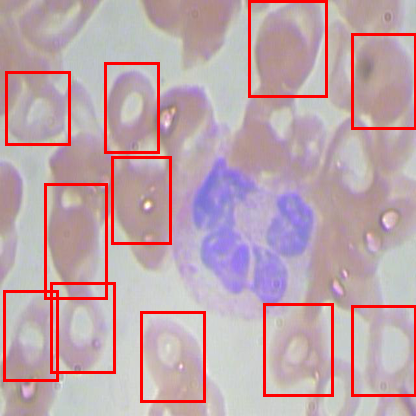

In [20]:
boundig_boxes = decode_bboxes_y_true(x_batch[0], y_batch[0])
pil_img = plot_bboxes(x_batch[0], boundig_boxes, width=3)
display(pil_img)

In [21]:
split = int(0.8*len(image_wrapper_list))
print('Train/Valid split:', split, '/', len(image_wrapper_list)-split)

Train/Valid split: 274 / 69


In [22]:
train_generator = BloodSequence(image_wrapper_list[:split],
                                target_size=416, number_cells=13, 
                                anchors=anchors, class_names=classes,
                                batch_size=16, shuffle=False,
                                preprocess_images_function=preproc_images)
valid_generator = BloodSequence(image_wrapper_list[split:],
                                target_size=416, number_cells=13, 
                                anchors=anchors, class_names=classes,
                                batch_size=16, shuffle=False,
                                preprocess_images_function=preproc_images)

# Test Model

In [23]:
from tensorflow.keras.layers import Input, Lambda, Reshape, concatenate
from tensorflow.keras.layers import Conv2D, BatchNormalization, LeakyReLU, MaxPooling2D
from tensorflow.keras.models import Model

In [24]:
class SpaceToDepth(tf.keras.layers.Layer):
    def __init__(self, block_size, **kwargs):
        super(SpaceToDepth, self).__init__(**kwargs)
        self.block_size = block_size
    
    def call(self, x):
        return tf.space_to_depth(x, self.block_size)

In [25]:
def conv_block(X, filters, kernel_size, suffix, max_pool=False):
    X = Conv2D(filters, kernel_size, strides=(1,1), padding='same',
               use_bias=False, name='conv'+suffix)(X)
    X = BatchNormalization(name='norm'+suffix)(X)
    X = LeakyReLU(alpha=0.1)(X)
    if max_pool:
        X = MaxPooling2D(pool_size=(2, 2))(X)
    return X

In [26]:
def create_yolov2(input_size, grid_size, number_anchors, number_classes):

    assert isinstance(input_size, (tuple, list)) and len(input_size) == 2
    assert isinstance(input_size[0], int) and input_size[0] > 0
    assert isinstance(input_size[1], int) and input_size[1] > 0
    assert isinstance(grid_size, (tuple, list)) and len(grid_size) == 2
    assert isinstance(grid_size[0], int) and grid_size[0] > 0
    assert isinstance(grid_size[1], int) and grid_size[1] > 0

    input_height, input_width = input_size
    grid_height, grid_width = grid_size

    IN = Input(shape=(input_height, input_width, 3))

    X = conv_block(IN, filters=32, kernel_size=(3,3), suffix='_1', max_pool=True)
    X = conv_block(X, filters=64, kernel_size=(3,3), suffix='_2', max_pool=True)
    X = conv_block(X, filters=128, kernel_size=(3,3), suffix='_3')
    X = conv_block(X, filters=64, kernel_size=(1,1), suffix='_4')
    X = conv_block(X, filters=128, kernel_size=(3,3), suffix='_5', max_pool=True)
    X = conv_block(X, filters=256, kernel_size=(3,3), suffix='_6')
    X = conv_block(X, filters=128, kernel_size=(1,1), suffix='_7')
    X = conv_block(X, filters=256, kernel_size=(3,3), suffix='_8', max_pool=True)
    X = conv_block(X, filters=512, kernel_size=(3,3), suffix='_9')
    X = conv_block(X, filters=256, kernel_size=(1,1), suffix='_10')
    X = conv_block(X, filters=512, kernel_size=(3,3), suffix='_11')
    X = conv_block(X, filters=256, kernel_size=(1,1), suffix='_12')
    X = conv_block(X, filters=512, kernel_size=(3,3), suffix='_13')

    SK = X  # skip connection

    X = MaxPooling2D(pool_size=(2, 2))(X)
    X = conv_block(X, filters=1024, kernel_size=(3,3), suffix='_14')
    X = conv_block(X, filters=512, kernel_size=(1,1), suffix='_15')
    X = conv_block(X, filters=1024, kernel_size=(3,3), suffix='_16')
    X = conv_block(X, filters=512, kernel_size=(1,1), suffix='_17')
    X = conv_block(X, filters=1024, kernel_size=(3,3), suffix='_18')
    X = conv_block(X, filters=1024, kernel_size=(3,3), suffix='_19')
    X = conv_block(X, filters=1024, kernel_size=(3,3), suffix='_20')

    SK = conv_block(SK, filters=64, kernel_size=(1,1), suffix='_21')
    SK = SpaceToDepth(block_size=2)(SK)
    X = concatenate([SK, X])

    X = conv_block(X, filters=1024, kernel_size=(3,3), suffix='_22')

    X = Conv2D(filters=number_anchors * (4+1+number_classes),
               kernel_size=(1,1), strides=(1,1), padding='same', name='conv_23')(X)
    
    OUT = Reshape((grid_height, grid_width, number_anchors, 4+1+number_classes))(X)

    model = Model(IN, OUT)
    return model

In [27]:
model = create_yolov2(input_size = (416, 416),  # (height, width)
                      grid_size = (13, 13),     # (height, width)
                      number_anchors = len(anchors),
                      number_classes = len(classes))

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor



In [28]:
# model.summary()

# Load YOLOv2 Weights

In [29]:
def load_yolov2_weights(model, filepath, last_layer='leave'):
    pointer = 4
    weights = np.fromfile(filepath, dtype='float32')

    for i in range(1, 23):

        #
        #   Norm layers 1..22
        #
        norm_layer = model.get_layer('norm_' + str(i))

        size = np.prod(norm_layer.get_weights()[0].shape)

        beta = weights[pointer:pointer+size]; pointer += size;
        gamma = weights[pointer:pointer+size]; pointer += size;
        mean = weights[pointer:pointer+size]; pointer += size;
        var = weights[pointer:pointer+size]; pointer += size;

        norm_layer.set_weights([gamma, beta, mean, var])

        #
        #   Conv layers 1..22
        #
        conv_layer = model.get_layer('conv_' + str(i))

        size = np.prod(conv_layer.get_weights()[0].shape)
        kernel = weights[pointer:pointer+size]; pointer += size;
        kernel = kernel.reshape(list(reversed(conv_layer.get_weights()[0].shape)))
        kernel = kernel.transpose([2,3,1,0])
        conv_layer.set_weights([kernel])

    #
    #   Conv layer 23
    #
    if last_layer == 'leave':
        pass
    
    elif last_layer == 'load':
        conv_layer = model.get_layer('conv_23')

        size = np.prod(conv_layer.get_weights()[1].shape)
        bias   = weights[pointer:pointer+size]; pointer += size;

        size = np.prod(conv_layer.get_weights()[0].shape)
        kernel = weights[pointer:pointer+size]; pointer += size;
        kernel = kernel.reshape(list(reversed(conv_layer.get_weights()[0].shape)))
        kernel = kernel.transpose([2,3,1,0])

        conv_layer.set_weights([kernel, bias])
        
    elif last_layer == 'rand':
        conv_layer = model.get_layer('conv_23') # the last convolutional layer
        weights = conv_layer.get_weights()
        
        output_shape = model.layers[-1].output_shape
        _, grid_w, grid_h, _, _ = output_shape
        
        new_kernel = np.random.normal(size=weights[0].shape) / (grid_w*grid_h)
        new_bias   = np.random.normal(size=weights[1].shape) / (grid_w*grid_h)

        conv_layer.set_weights([new_kernel, new_bias])
    
    else:
        raise ValueError("Parameter last_layer must be 'leave', 'load' or 'rand'.")

In [30]:
np.random.seed(0)

In [31]:
load_yolov2_weights(model, 'yolov2.weights', last_layer='rand')

In [32]:
netout = model.predict(x_batch)

In [33]:
np.round(netout[0][1][8], 2)

array([[ 0.05, -0.05, -0.09,  0.26,  0.03,  0.2 ],
       [-0.21, -0.11,  0.13,  0.04,  0.08, -0.  ],
       [-0.13, -0.03, -0.11, -0.23,  0.08, -0.05],
       [ 0.08,  0.05,  0.05, -0.03, -0.11, -0.21],
       [-0.05, -0.04, -0.03, -0.1 ,  0.15, -0.08]], dtype=float32)

In [34]:
# np.save('netout.npz', netout)

In [35]:
netout_ref = np.load('netout.npz.npy')

In [36]:
np.all(netout == netout_ref)

True

In [37]:
np.abs(netout - netout_ref).max()

0.0

# Loss Function

This function was mostly copied form [keras-yolo2](https://github.com/experiencor/keras-yolo2). All credit goes to original authors.

I have made **two modifications** to original YOLOv2 loss.

1. I removed one term from the loss function, which was responsible for penalising low IoU false positives. I found that it made almost no difference on model performance (at least at this dataset), while being unreasonably complex to compute. The full version of YOLOv2 the loss function is available at the end of this notebook.
2. I removed the warm-up section. Again, I found it was introducing complexity, while actually making results worse.

The **full YOLOv2** loss function is available in the appending at the bottom of this notebook.

My changes:
* simplify by removing low IoU penalty
* simplify by removing warmup code
* remove statistics (recall) and debug prints
* rewrite and extend comments
* explicitly declare global variables

In [38]:
def yolov2_loss_full(y_true, y_pred):
    global anchors, lambda_coord, lambda_noobj, lambda_obj, lambda_class, class_weights
    
    #
    #   Prepare empty masks
    #
    nb_batch = tf.shape(y_true)[0]
    nb_grid_w = tf.shape(y_true)[1]
    nb_grid_h = tf.shape(y_true)[2]
    nb_anchor = tf.shape(y_true)[3]
    nb_class = tf.shape(y_true)[4] - 5    # substract x,y,w,h,conf fields
    
    coord_mask = tf.zeros(shape=(nb_batch, nb_grid_w, nb_grid_h, nb_anchor))
    conf_mask  = tf.zeros(shape=(nb_batch, nb_grid_w, nb_grid_h, nb_anchor))
    class_mask = tf.zeros(shape=(nb_batch, nb_grid_w, nb_grid_h, nb_anchor))
    
    #
    #   Decode Predictions
    #
    
    # create grid_coord so we can offset predictions by grid cell index
    grid_tiles = tf.tile(tf.range(nb_grid_w), [nb_grid_h])
    grid_resh = tf.reshape(grid_tiles, (1, nb_grid_h, nb_grid_w, 1, 1))
    grid_x = tf.to_float(grid_resh)
    grid_y = tf.transpose(grid_x, (0,2,1,3,4))
    grid_concat = tf.concat([grid_x,grid_y], -1)
    grid_coord = tf.tile(grid_concat, [nb_batch, 1, 1, nb_anchor, 1])
    
    # transform logits to 0..1, then add cell offsets
    # shape [b, gw, gh, a, 2], range [0..gx, 0..gy], dtype float
    pred_box_xy = tf.sigmoid(y_pred[..., :2]) + grid_coord
       
    # transform logits to bounding box width and height
    # shape [b, gw, gh, a, 2], range [0..], dtype float
    # value of [1, 1] means bbox is same as anchor, [.5,.5] means half anchor
    pred_box_wh = tf.exp(y_pred[..., 2:4]) * np.reshape(anchors, [1,1,1,len(anchors),2])
    
    # logits to confidence
    pred_box_conf = tf.sigmoid(y_pred[..., 4])
    
    # for class probabilites keep logits as (passed to cross-entropy later)
    pred_box_class = y_pred[..., 5:]
    
    #
    #   Decode targets
    #
    
    # target xywh are alredy correctly formatted
    # shape [b, gw, gh, a, 2], range [0..gx, 0..gy], dtype float
    # value [1.5, 2.5] means bbox center is aligned with center of cell [1, 2]
    true_box_xy = y_true[..., 0:2]
    true_box_wh = y_true[..., 2:4]
    
    # this whole section basically computes IoU(true_bbox, pred_bbox)
    true_wh_half = true_box_wh / 2.
    true_mins    = true_box_xy - true_wh_half
    true_maxes   = true_box_xy + true_wh_half
    pred_wh_half = pred_box_wh / 2.
    pred_mins    = pred_box_xy - pred_wh_half
    pred_maxes   = pred_box_xy + pred_wh_half       
    intersect_mins  = tf.maximum(pred_mins,  true_mins)
    intersect_maxes = tf.minimum(pred_maxes, true_maxes)
    intersect_wh    = tf.maximum(intersect_maxes - intersect_mins, 0.)
    intersect_areas = intersect_wh[..., 0] * intersect_wh[..., 1]
    true_areas = true_box_wh[..., 0] * true_box_wh[..., 1]
    pred_areas = pred_box_wh[..., 0] * pred_box_wh[..., 1]
    union_areas = pred_areas + true_areas - intersect_areas
    iou_scores  = tf.truediv(intersect_areas, union_areas)
    
    # target confidence is defined as: class_prob * IoU(true_bbox, pred_bbox)
    # note that in this dataset class_prob is always 0 or 1
    true_box_conf = iou_scores * y_true[..., 4]
    
    # convert class vector from one-hot to integer [0..]
    true_box_class = tf.argmax(y_true[..., 5:], -1)
    
    #
    #   Penalty for low IoU predictions (optionsl)
    #
    
    # confidence mask: penelize predictors + penalize boxes with low IOU
    shape = tf.shape(y_true)
    y_true_reduce = y_true[...,0:4]
    y_true_reshape = tf.reshape(y_true_reduce, shape=(shape[0], -1, 4))
    y_true_max = tf.reduce_max(y_true_reshape, axis=-1)
    y_true_argsorg = tf.argsort(y_true_max, axis=-1)
    y_true_range = tf.tile(tf.expand_dims(tf.range(shape[0]), 1), [1, 845])
    y_true_stack = tf.stack([y_true_range, y_true_argsorg], axis=-1)
    y_true_2 = tf.gather_nd(y_true_reshape, y_true_stack)
    y_true_3 = y_true_2[:,-50:,:]  # 50 is box buffer size
    y_true_3d = tf.expand_dims(y_true_3, axis=1)
    y_true_3dd = tf.expand_dims(y_true_3d, axis=1)
    y_true_3ddd = tf.expand_dims(y_true_3dd, axis=1)
    true_xy = y_true_3ddd[..., 0:2]
    true_wh = y_true_3ddd[..., 2:4]
    
    # this whole section basically computes IoU(true_bbox, pred_bbox)
    true_wh_half = true_wh / 2.
    true_mins    = true_xy - true_wh_half
    true_maxes   = true_xy + true_wh_half
    pred_xy = tf.expand_dims(pred_box_xy, 4)
    pred_wh = tf.expand_dims(pred_box_wh, 4)
    pred_wh_half = pred_wh / 2.
    pred_mins    = pred_xy - pred_wh_half
    pred_maxes   = pred_xy + pred_wh_half    
    intersect_mins  = tf.maximum(pred_mins,  true_mins)
    intersect_maxes = tf.minimum(pred_maxes, true_maxes)
    intersect_wh    = tf.maximum(intersect_maxes - intersect_mins, 0.)
    intersect_areas = intersect_wh[..., 0] * intersect_wh[..., 1]
    true_areas = true_wh[..., 0] * true_wh[..., 1]
    pred_areas = pred_wh[..., 0] * pred_wh[..., 1]
    union_areas = pred_areas + true_areas - intersect_areas
    iou_scores  = tf.truediv(intersect_areas, union_areas)
    best_ious = tf.reduce_max(iou_scores, axis=4)
    
    #
    #   Compute 0/1 masks
    #
    
    # coordinate mask: the position of the ground truth boxes (the predictors)
    coord_mask = tf.expand_dims(y_true[..., 4], axis=-1) * lambda_coord
    
    # confidence mask: the confidence of the ground truth boxes
    conf_mask = conf_mask + tf.to_float(best_ious < 0.6) * (1 - y_true[..., 4]) * lambda_noobj
    #conf_mask = conf_mask + (1 - y_true[..., 4]) * lambda_noobj
    conf_mask = conf_mask + y_true[..., 4] * lambda_obj
    
    # class mask: the class of the ground truth boxes
    class_mask = y_true[..., 4] * tf.gather(class_weights, true_box_class) * lambda_class       
    

    #
    #   Warmup (optional)
    #
#     no_boxes_mask = tf.to_float(coord_mask < lambda_coord/2.)
#     seen = tf.assign_add(seen, 1.)
#     num_warmup = 100
#     true_box_xy, true_box_wh, coord_mask = tf.cond(tf.less(seen, num_warmup),
#         lambda: [true_box_xy + (0.5 + cell_grid) * no_boxes_mask, 
#                  true_box_wh + tf.ones_like(true_box_wh)*np.reshape(anchors,[1,1,1,len(anchors),2])*no_boxes_mask, 
#                  tf.ones_like(coord_mask)],
#         lambda: [true_box_xy, 
#                  true_box_wh,
#                  coord_mask])
    
    #
    #   Combine the loss
    #
    nb_coord_box = tf.reduce_sum(tf.to_float(coord_mask > 0.0))
    nb_conf_box  = tf.reduce_sum(tf.to_float(conf_mask  > 0.0))
    nb_class_box = tf.reduce_sum(tf.to_float(class_mask > 0.0))
    
    loss_xy    = tf.reduce_sum(tf.square(true_box_xy-pred_box_xy)     * coord_mask) / (nb_coord_box + 1e-6) / 2.
    loss_wh    = tf.reduce_sum(tf.square(true_box_wh-pred_box_wh)     * coord_mask) / (nb_coord_box + 1e-6) / 2.
    loss_conf  = tf.reduce_sum(tf.square(true_box_conf-pred_box_conf) * conf_mask)  / (nb_conf_box  + 1e-6) / 2.
    loss_class = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=true_box_class, logits=pred_box_class)
    loss_class = tf.reduce_sum(loss_class * class_mask) / (nb_class_box + 1e-6)
    
    loss = loss_xy + loss_wh + loss_conf + loss_class
    
    
    #
    #   Recall and debug (optional)
    #  
#     nb_true_box = tf.reduce_sum(y_true[..., 4])
#     nb_pred_box = tf.reduce_sum(tf.to_float(true_box_conf > 0.5) * tf.to_float(pred_box_conf > 0.3))
#     batch_recall = nb_pred_box/(nb_true_box + 1e-6)  # mini-batch recall

#     loss = tf.Print(loss, [tf.zeros((1))], message='Dummy Line \t', summarize=1000)
#     loss = tf.Print(loss, [loss_xy], message='Loss XY \t', summarize=1000)
#     loss = tf.Print(loss, [loss_wh], message='Loss WH \t', summarize=1000)
#     loss = tf.Print(loss, [loss_conf], message='Loss Conf \t', summarize=1000)
#     loss = tf.Print(loss, [loss_class], message='Loss Class \t', summarize=1000)
#     loss = tf.Print(loss, [loss], message='Total Loss \t', summarize=1000)
#     loss = tf.Print(loss, [batch_recall], message='Current Recall \t', summarize=1000)
    
    return loss

In [39]:
batches = BloodSequence(image_wrapper_list, target_size=416, number_cells=13, 
                        anchors=anchors, class_names=classes, batch_size=16, shuffle=False,
                       preprocess_images_function=preproc_images)

In [40]:
x_batch, y_batch = batches[0]

In [41]:
y_hat = model.predict(x_batch)

In [42]:
y_true_ph = tf.placeholder(tf.float32, shape=(None, 13, 13, 5, 6))
y_pred_ph = tf.placeholder(tf.float32, shape=(None, 13, 13, 5, 6))
loss = yolov2_loss_full(y_true_ph, y_pred_ph)

Instructions for updating:
Use `tf.cast` instead.


In [43]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    res = sess.run(loss, {y_true_ph: y_batch, y_pred_ph: y_hat})

In [44]:
res

0.679627

```
Simple:  0.6796268
Full:    0.6796271
```

In [45]:
optimizer = tf.keras.optimizers.Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
model.compile(loss=yolov2_loss_full, optimizer=optimizer)

In [46]:
earlystop_cb = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0.001, patience=3, mode='min', verbose=1)
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    'model.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='min', period=1)

In [47]:
hist = model.fit_generator(generator=train_generator, 
                           steps_per_epoch=len(train_generator), 
                           epochs=100, 
                           verbose=1,
                           validation_data=valid_generator,
                           validation_steps=len(valid_generator),
                           callbacks=[checkpoint_cb],
                           max_queue_size=3)

Epoch 1/100
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
17/18 [===========================>..] - ETA: 0s - loss: 0.3375
Epoch 00001: val_loss improved from inf to 0.26446, saving model to model.h5
18/18 [==============================] - 19s 1s/step - loss: 0.3325 - val_loss: 0.2645
Epoch 2/100
17/18 [===========================>..] - ETA: 0s - loss: 0.1989
Epoch 00002: val_loss improved from 0.26446 to 0.21141, saving model to model.h5
18/18 [==============================] - 8s 431ms/step - loss: 0.1964 - val_loss: 0.2114
Epoch 3/100
17/18 [===========================>..] - ETA: 0s - loss: 0.1269
Epoch 00003: val_loss improved from 0.21141 to 0.19352, saving model to model.h5
18/18 [==============================] - 7s 416ms/step - loss: 0.1260 - val_loss: 0.1935
Epoch 4/100
17/18 [===========================>..] - ETA: 0s - loss: 0.0762
Epoch 00004: val_loss improved from 0.19352 to 0.14761, saving model to model.h5
18/18 [==========

Epoch 35/100
17/18 [===========================>..] - ETA: 0s - loss: 0.0038
Epoch 00035: val_loss did not improve from 0.07532
18/18 [==============================] - 5s 273ms/step - loss: 0.0038 - val_loss: 0.0759
Epoch 36/100
17/18 [===========================>..] - ETA: 0s - loss: 0.0033
Epoch 00036: val_loss did not improve from 0.07532
18/18 [==============================] - 5s 276ms/step - loss: 0.0033 - val_loss: 0.0765
Epoch 37/100
17/18 [===========================>..] - ETA: 0s - loss: 0.0031
Epoch 00037: val_loss did not improve from 0.07532
18/18 [==============================] - 5s 279ms/step - loss: 0.0031 - val_loss: 0.0772
Epoch 38/100
17/18 [===========================>..] - ETA: 0s - loss: 0.0032
Epoch 00038: val_loss did not improve from 0.07532
18/18 [==============================] - 5s 278ms/step - loss: 0.0032 - val_loss: 0.0763
Epoch 39/100
17/18 [===========================>..] - ETA: 0s - loss: 0.0041
Epoch 00039: val_loss did not improve from 0.07532
18/1

17/18 [===========================>..] - ETA: 0s - loss: 0.0020
Epoch 00072: val_loss did not improve from 0.07276
18/18 [==============================] - 5s 260ms/step - loss: 0.0019 - val_loss: 0.0740
Epoch 73/100
17/18 [===========================>..] - ETA: 0s - loss: 0.0015
Epoch 00073: val_loss did not improve from 0.07276
18/18 [==============================] - 5s 258ms/step - loss: 0.0015 - val_loss: 0.0768
Epoch 74/100
17/18 [===========================>..] - ETA: 0s - loss: 0.0031
Epoch 00074: val_loss did not improve from 0.07276
18/18 [==============================] - 5s 267ms/step - loss: 0.0030 - val_loss: 0.0738
Epoch 75/100
17/18 [===========================>..] - ETA: 0s - loss: 0.0025
Epoch 00075: val_loss did not improve from 0.07276
18/18 [==============================] - 5s 263ms/step - loss: 0.0025 - val_loss: 0.0743
Epoch 76/100
17/18 [===========================>..] - ETA: 0s - loss: 0.0024
Epoch 00076: val_loss did not improve from 0.07276
18/18 [==========

In [48]:
import pickle

In [49]:
with open('/home/marcin/Repos/keras-yolo2/hist_original.pkl', 'rb') as f:
    hist_original = pickle.load(f)
with open('/home/marcin/Repos/keras-yolo2/hist_original_2.pkl', 'rb') as f:
    hist_original_2 = pickle.load(f)
with open('/home/marcin/Repos/keras-yolo2/hist_original_3.pkl', 'rb') as f:
    hist_original_3 = pickle.load(f)

with open('/home/marcin/Repos/keras-yolo2/hist_no_warmup.pkl', 'rb') as f:
    hist_no_warmup = pickle.load(f)

with open('/home/marcin/Repos/keras-yolo2/hist_no_jitter.pkl', 'rb') as f:
    hist_no_jitter = pickle.load(f)

with open('/home/marcin/Repos/keras-yolo2/hist_no_warmup_no_jiter.pkl', 'rb') as f:
    hist_no_warmup_no_jiter = pickle.load(f)
with open('/home/marcin/Repos/keras-yolo2/hist_no_warmup_no_jiter_2.pkl', 'rb') as f:
    hist_no_warmup_no_jiter_2 = pickle.load(f)

with open('/home/marcin/Repos/keras-yolo2/hist_no_warmup_no_jiter_simple_loss.pkl', 'rb') as f:
    hist_no_warmup_no_jiter_simple_loss = pickle.load(f)

(0, 0.2)

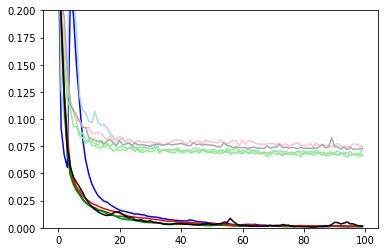

In [50]:
# plt.plot(hist_original['loss'], c='blue')
# plt.plot(hist_original['val_loss'], c='blue')
# plt.plot(hist_original_2['loss'], c='lightblue')
# plt.plot(hist_original_2['val_loss'], c='lightblue')
# plt.plot(hist_original_3['loss'], c='lightblue')
# plt.plot(hist_original_3['val_loss'], c='lightblue')
# plt.plot(hist_no_warmup['loss'], c='red')
# plt.plot(hist_no_warmup['val_loss'], c='pink')
plt.plot(hist_no_jitter['loss'], c='blue')
plt.plot(hist_no_jitter['val_loss'], c='lightblue')
plt.plot(hist_no_warmup_no_jiter['loss'], c='green')
plt.plot(hist_no_warmup_no_jiter['val_loss'], c='lightgreen')
plt.plot(hist_no_warmup_no_jiter_2['loss'], c='green')
plt.plot(hist_no_warmup_no_jiter_2['val_loss'], c='lightgreen')
plt.plot(hist_no_warmup_no_jiter_simple_loss['loss'], c='red')
plt.plot(hist_no_warmup_no_jiter_simple_loss['val_loss'], c='pink')
plt.plot(hist.history['loss'], c='black')
plt.plot(hist.history['val_loss'], c='darkgray')

plt.ylim((0, .2))

In [51]:
def sigmoid(x):
    return 1 / (1+np.exp(-x))

In [52]:
def softmax(x):
    max_ = np.max(x, axis=-1, keepdims=True)
    ex = np.exp(x - max_)
    ex_sum = np.sum(ex, axis=-1, keepdims=True)
    return ex / ex_sum

In [56]:
def iou(bboxA, bboxB):
    # intersect rectangle
    xmin = max(bboxA.xmin, bboxB.xmin)
    ymin = max(bboxA.ymin, bboxB.ymin)
    xmax = min(bboxA.xmax, bboxB.xmax)
    ymax = min(bboxA.ymax, bboxB.ymax)
    
    areaI = max(0, xmax-xmin+1) * max(0, ymax-ymin+1)
    areaA = (bboxA.xmax-bboxA.xmin+1) * (bboxA.ymax-bboxA.ymin+1)
    areaB = (bboxB.xmax-bboxB.xmin+1) * (bboxB.ymax-bboxB.ymin+1)
    
    return areaI / (areaA + areaB - areaI)